In [191]:
#ライブラリのimportを行います
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#scikit-learnはsklearnでインポート可能
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_percentage_error

from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [192]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [193]:
train["price"] = np.log1p(train["price"])
train["price"] = np.log(train["price"])

In [194]:
# trainデータとtestデータを結合
data = pd.concat([train, test], ignore_index=True)
data = data.drop("id", axis=1)

In [195]:
#data.loc[(data["fuel"] == "electric") & (data["year"] <= 1940)].head()


In [196]:
# stateを削除する
data = data.drop("state", axis=1)
#data = data.drop("region", axis=1)
# data = data.drop("manufacturer", axis=1)
# 電気自動車のおかしいデータを修正する
data.loc[(data["fuel"] == "electric") & (data["year"] <= 1940), "fuel"] = "gas"

In [197]:
# カラムの値を処理する関数
def process_column_value(value):
    # スペースとスラッシュを削除
    cleaned_value = value.replace(' ', '').replace('/', '').replace(',', '')

    # 全角文字を半角に変換
    half_width_value = cleaned_value.encode('ascii', 'ignore').decode('utf-8')

    return half_width_value

# カラムの値を処理
data['region'] = data['region'].apply(process_column_value)

In [198]:
# yearの誤植訂正
for i in [2999, 3008, 3017, 3015, 3019, 3011]:
    data.loc[data["year"] == i, "year"] = i - 1000

In [199]:
# manufacturerを小文字に変換する
data["manufacturer"] = data["manufacturer"].str.lower()
# manufacturer内の文字列を全て半角に変換する関数
def to_half_width(text):
    return ''.join([unicodedata.normalize('NFKC', char) for char in text])

# manufacturerのカラム内の文字列を半角に変換
data["manufacturer"] = data["manufacturer"].apply(to_half_width)
data["manufacturer"].describe()

def to_half_width(text):
    return ''.join([unicodedata.normalize('NFKC', char).lower().replace("а", "a").replace("ѕ", "s").replace("о", "o").replace("α", "a").replace("ᴄ", "c") for char in text])

data["manufacturer"] = data["manufacturer"].apply(to_half_width)

data["manufacturer"].describe()

count     55069
unique       37
top        ford
freq      13890
Name: manufacturer, dtype: object

In [200]:
# cylindersの変更
cylmap = {'6 cylinders': 6, '8 cylinders': 8, '4 cylinders': 4, 'other': 0,
          '10 cylinders': 10, '12 cylinders': 12, '5 cylinders': 5, '3 cylinders': 3}
data["cylinders"] = data.cylinders.map(cylmap)

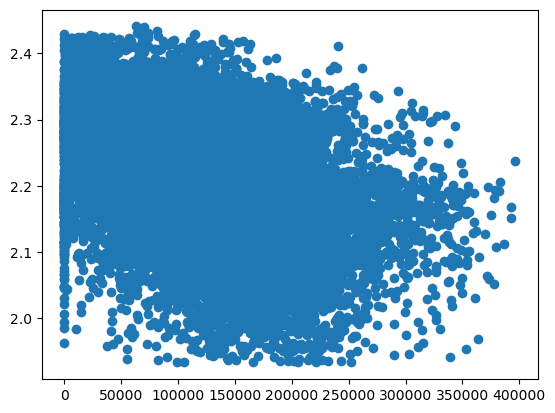

In [201]:
# odometerの修正
data.loc[data["odometer"] == -131869, "odometer"] = 131869
#data.loc[data["odometer"] >= 3000000, "odometer"] = data.loc[data["odometer"] >= 3000000, "odometer"] / 10
data = data[data["odometer"] < 1000000]
train = train[train["odometer"] < 1000000]
test = test[test["odometer"] < 1000000]
# -1はexcelentのodometerの平均値で補完
# data["odometer"] = data["odometer"].replace(-1, data[data["condition"] == "excellent"]["odometer"].mean())

plt.scatter(data["odometer"], data["price"])

In [202]:
data['size'] = data['size'].str.replace('full-size', 'fullsize').replace('fullーsize', 'fullsize').replace('full−size', 'fullsize').replace('mid-size', 'midsize').replace('midーsize', 'midsize').replace('mid−size', 'midsize').replace('sub-compact','subcompact').replace('subーcompact', 'subcompact')

In [203]:
# # conditionを数値にする
# replacement_dict = {'fair': 1, 'salvage': 2, 'good': 3, 'new': 4, 'excellent': 5, 'like new': 6}
# data['condition'] = data['condition'].replace(replacement_dict)

# # title_statusを数値にする
# replacement_dict = {'clean': 4, 'lien': 6, 'rebuilt': 5, 'salvage': 3, 'missing': 1, 'parts only': 2}
# data['title_status'] = data['title_status'].replace(replacement_dict)

# data["conditon_status"] = data["condition"] ** 2 *  data["title_status"]

# #sizeを数値にする
# replacement_dict = {'fullsize': 4, 'midsize': 3, 'subcompact': 2, 'compact': 1}
# data['size'] = data['size'].replace(replacement_dict)

# #driveを数値にする
# # replacement_dict = {'fwd': 1, 'rwd': 2, '4wd': 3}
# # data['drive'] = data['drive'].replace(replacement_dict)

# # # #size * drive
# # data['size_drive'] = data['odometer'] / data['drive']

# replace = {"other" : 3, "gas" : 1, "diesel" : 2, "hybrid" : 4, "electric" : 5}
# # data['fuel'] = data['fuel'].replace(replace)
# # data["ddd"] = data["odometer"] / data["fuel"]

In [204]:
# data["odometer"] = np.sqrt(data["odometer"])

In [205]:
# data["year_odometer1"] = data["year"] * data["odometer"] 
# data["year_condition"] = data["year"] / data["condition"]
# data["year_odometer2"] = data["odometer"] / data["year"]
# data["year_condition2"] = data["odometer"] / data["condition"] 

In [206]:
# # 色ごとに数値を割り当てる辞書
# color_mapping = {
#     "silver": 4,
#     "grey": 3,
#     "black": 2,
#     "white": 1
# }

# # 条件に合致する行の色を数値に変換
# data["paint_color"] = data["paint_color"].map(color_mapping)

# # 条件に合致しない行に対する処理（ここでは0を割り当てる）
# data["paint_color"].fillna(0, inplace=True)

In [207]:
# agg_cols = ['min', 'max', 'mean', 'std']
# cat_cols = ["fuel","type","paint_color", "title_status", "size", "drive"]

# for col in cat_cols:
#     grp_df = data.groupby(col)["odometer"].agg(agg_cols)
#     grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
#     data = data.merge(grp_df, on=col, how='left')


In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55063 entries, 0 to 55068
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        55063 non-null  object 
 1   year          55063 non-null  int64  
 2   manufacturer  55063 non-null  object 
 3   condition     55063 non-null  object 
 4   cylinders     55063 non-null  int64  
 5   fuel          52330 non-null  object 
 6   odometer      55063 non-null  int64  
 7   title_status  54379 non-null  object 
 8   transmission  55063 non-null  object 
 9   drive         55063 non-null  object 
 10  size          55063 non-null  object 
 11  type          54379 non-null  object 
 12  paint_color   55063 non-null  object 
 13  price         27526 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 6.3+ MB


In [209]:
# # グループごとの年平均を計算
# C = data.groupby("manufacturer")["year"].mean()
# #D = data.groupby("manufacturer")["odometer"].std()

# # グループごとの平均年を新しいカラムとして追加
# data["mean_year"] = data["manufacturer"].map(C)
# #data["W"] = data["manufacturer"].map(D)

# # # 新しいカラムを計算
# # data["manu_year"] = data["year"] / data["mean_year"] * data["W"]
# # data = data.drop("mean_year", axis=1)
# # data = data.drop("W", axis=1)

# # # train.groupby(["drive", "size"])["price"].agg(["mean", "count"])
# # # data["si_dri"] = data["drive"] ** 2 / data["year"]
# # # data["Q"] = data["drive"] * data["cylinders"] * data["size"] 

In [210]:
#data = data.drop(['title_status'], axis=1)
# data = data.drop(['transmission'], axis=1)
# data = data.drop(['drive'], axis=1)
# data = data.drop(['size'], axis=1)

In [211]:
# cols = ["type", "paint_color"]

# for col in cols:
#     # "odometer" カラムをキーにして、基本情報量のカラムを新しく追加
#     basic_info = data.groupby(col)["odometer"].agg(["mean"]).reset_index()
#     basic_info.columns = [col, f"{col}_mean_odometer"]

#     # 元のデータに基本情報量のカラムを結合
#     data = data.merge(basic_info, on=col, how="left")

In [212]:
# data["C"] = np.where(data["paint_color"].isin(["black", "white", "silver", "gray"]), 1, 0)
# data = data.drop(columns=["transmission"], axis=1)
# data = data.drop("cylinders",axis=1)

In [213]:
# # ワンホットエンコーディングする
# data = pd.get_dummies(data, columns=["fuel"])

# LabelEncoderのインスタンスを作成
label_encoder = LabelEncoder()

# カテゴリ変数を数値にエンコード
data['region'] = label_encoder.fit_transform(data['region'])
data['manufacturer'] = label_encoder.fit_transform(data['manufacturer'])
data['condition'] = label_encoder.fit_transform(data['condition'])
data['fuel'] = label_encoder.fit_transform(data['fuel'])
data['transmission'] = label_encoder.fit_transform(data['transmission'])
data['type'] = label_encoder.fit_transform(data['type'])
data['paint_color'] = label_encoder.fit_transform(data['paint_color'])
data['title_status'] = label_encoder.fit_transform(data['title_status'])
data['drive'] = label_encoder.fit_transform(data['drive'])
data['size'] = label_encoder.fit_transform(data['size'])      
#data["state"] = label_encoder.fit_transform(data['state'])                    


In [214]:
# 再びtrainデータとtestデータに戻す
train = data.iloc[:len(train)]
test = data.iloc[len(train):]
print(train.shape)
print(test.shape)

(27526, 14)
(27537, 14)


In [215]:
y = train["price"]
X = train.drop(["price"], axis=1)
test = test.drop(["price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lgb_train = lgb.Dataset(X_train, y_train)

In [216]:
# def objective(trial):
#     # ハイパーパラメータの範囲を設定
#     params = {
#         'objective': 'regression',
#         'metric': 'mape',
#         'boosting_type': 'gbdt',
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.9),  # 追加: ツリー構築時に使用する特徴量の割合
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8),  # 追加: ブートストラップサンプリングを行う割合
#         'lambda_l1': trial.suggest_float('lambda_l1', 0.05, 0.1),         # 追加: L1正則化の係数
#         'min_split_gain': trial.suggest_float('min_split_gain', 0.01, 0.02),   # 追加: 分割が行われるための最小の情報利得
#         'verbose': -1
#     }

#     # モデルの学習と評価
#     train_data = lgb.Dataset(X_train, label=y_train)
#     model = lgb.train(params, train_data)
#     # 評価指標（例: MAPE）を最小化するように設定
#     mape = mean_absolute_percentage_error(y_train, model.predict(X_train))
#     return mape


In [217]:
# study = optuna.create_study(direction='minimize')  # 最小化問題
# study.optimize(objective, n_trials=100)  # n_trialsは試行回数
# best_params = study.best_params
# print("Best parameters:", best_params)


In [218]:
# # ハイパーパラメータを設定
# params = {
#     'objective': 'regression',   # 目的関数: 回帰
#     'metric': 'mape',             # 評価指標: 平均二乗誤差
#     'boosting_type': 'gbdt',     # 勾配ブースティング
#     'num_leaves': 80,            # ツリーの葉の数
#     'learning_rate': 0.1,        # 学習率
#     "max_depth": 7,             # 木の深さ
#     'verbose': -1               #学習情報を非表示
# }

In [219]:
best_param = {
    'objective': 'regression',   # 目的関数: 回帰
    'metric': 'mape',             # 評価指標: 平均二乗誤差
    'boosting_type': 'gbdt',     # 勾配ブースティング
    'num_leaves': 80,            # ツリーの葉の数
    'learning_rate': 0.08,        # 学習率
    "max_depth": 10,             # 木の深さ
    'feature_fraction': 0.73, 
    'bagging_fraction': 0.64, 
    'lambda_l1': 0.072, 
    'min_split_gain': 0.01,
    'verbose': -1               #学習情報を非表示    
}

In [220]:
# params = {
#     'objective': 'regression',
#     'metric': 'mape',
#     'boosting_type': 'gbdt',
#     'num_leaves': 90,
#     'learning_rate': 0.1,
#     'max_depth': 12,
#     # 'feature_fraction': 0.7,  # 追加: ツリー構築時に使用する特徴量の割合
#     # 'bagging_fraction': 0.7,  # 追加: ブートストラップサンプリングを行う割合
#     # 'lambda_l1': 0.1,         # 追加: L1正則化の係数
#     # 'min_split_gain': 0.01,   # 追加: 分割が行われるための最小の情報利得
#     'verbose': -1
# }


In [221]:
# # モデルを訓練
# num_round = 100  # イテレーション数
# model = lgb.train(best_param, lgb_train, num_round)

In [222]:
# モデルを訓練
num_round = 100  # イテレーション数
model_2 = lgb.train(best_param, lgb_train, num_round)

In [223]:
#predict()で予測できます。()内に予測したいデータを入れることで予測できます。
#pred = model.predict(X_test)
pred_2 = model_2.predict(X_test)

In [224]:
# # 小数点は四捨五入する
# # 0.5以上なら切り上げ、0.5未満なら切り捨て
#pred = np.exp(np.exp(pred)) - 1
y_test = np.exp(np.exp(y_test)) -1
# # pred = np.round(pred)
# print(pred[:20])
# print(y_test[:20])

In [225]:
predd = np.exp(np.exp(pred_2)) - 1
print(pred_2[:20])

[2.21147874 2.16000505 2.20852238 2.17825722 2.16284656 2.15029464
 2.17020648 2.1904682  2.21221303 2.18082173 2.34119765 2.23270493
 2.17332196 2.22158643 2.27544368 2.28331712 2.16362487 2.25422568
 2.20708889 2.35396538]


In [226]:
X_test.head()

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
14120,240,2004,11,2,6,2,47389,0,1,2,2,3,8
5235,205,2006,7,2,8,2,110102,0,0,1,1,9,0
12622,276,1999,11,1,8,0,135362,0,0,0,1,0,0
23931,228,2012,34,0,4,2,94135,0,0,1,0,9,4
5045,33,2007,11,2,8,2,151023,0,0,1,1,8,0


In [227]:
# pred_u = (pred * 4  + pred_2) / 5

In [228]:
#MAPEの評価はmean_absolute_percentage_error(正解データ, 予測データ)で可能です。
#score = mean_absolute_percentage_error(y_test, pred)
score_2 = mean_absolute_percentage_error(y_test, predd)
#score_3 = mean_absolute_percentage_error(y_test, pred_u)

#print(score*100)
print(score_2*100)
#print(score_3*100)

51.79230735575378


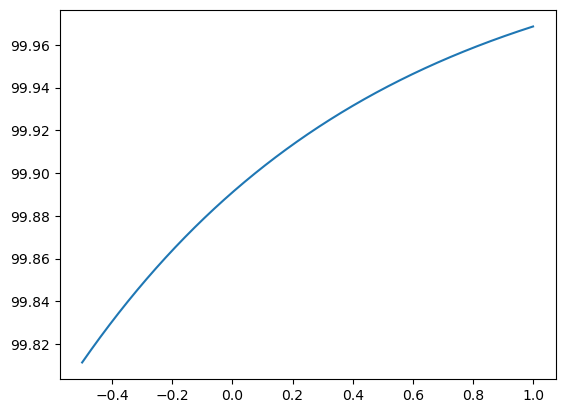

-0.5 :  99.81135341092752


In [229]:
ii = np.arange(-.5, 1, 0.0005)
ind = 0
mi = 999
ss = []
for i in ii:
    logy_pred = np.exp(pred_2 - i) - 1
    s = mean_absolute_percentage_error(y_test, logy_pred) * 100
    ss.append(s)
    if s < mi:
        mi = s
        ind = i
plt.plot(ii, ss)
plt.show()
print(ind, ": ", mi)

In [230]:
predict = model.predict(test)
predict_2 = model_2.predict(test)
#predict = (predict * 4 + predict_2) / 5
predict = np.exp(np.exp(predict)) - 1
#submit_sample.csvを読み込みます。
submit = pd.read_csv("submit_sample.csv", header=None)
submit.head()
#submit_sampleのpriceの数値部分を予測データpredictに変更する
# predict = np.round(predict)
submit[1] = predict
#確認してみましょう
submit.head()

NameError: name 'model' is not defined

In [ ]:
#submission.csvでデータを保存(提出様式はindex=False, header=Noneとなります。)
submit.to_csv("submit_sample.csv", index=False, header=None)

Feature 1: region, Importance: 1481
Feature 2: year, Importance: 1392
Feature 3: manufacturer, Importance: 852
Feature 4: condition, Importance: 476
Feature 5: cylinders, Importance: 266
Feature 6: fuel, Importance: 156
Feature 7: odometer, Importance: 1909
Feature 8: title_status, Importance: 238
Feature 9: transmission, Importance: 181
Feature 10: drive, Importance: 288
Feature 11: size, Importance: 247
Feature 12: type, Importance: 677
Feature 13: paint_color, Importance: 623


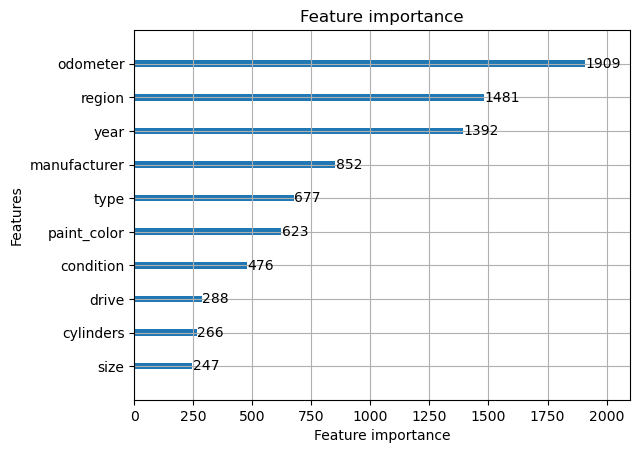

In [ ]:
# 特徴量の重要度の取得
feature_importance = model_2.feature_importance()

# 特徴量の名前
feature_names = model_2.feature_name()

# 特徴量の重要度を表示
for i, (name, importance) in enumerate(zip(feature_names, feature_importance)):
    print(f"Feature {i+1}: {name}, Importance: {importance}")

# 特徴量の重要度を可視化
lgb.plot_importance(model_2, importance_type='split', max_num_features=10)  # splitやgainなどの指標を選択可能
plt.show()